C:\Users\lionl\AppData\Local\Temp\ipykernel_3452\2303433966.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


Number of clusters: 2
Number of noise points: 5 (0.12% of data)

Cluster Summary:
        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
-1          2.6     500.0  512411.8     5
 0         92.7       4.2    1786.5  4331


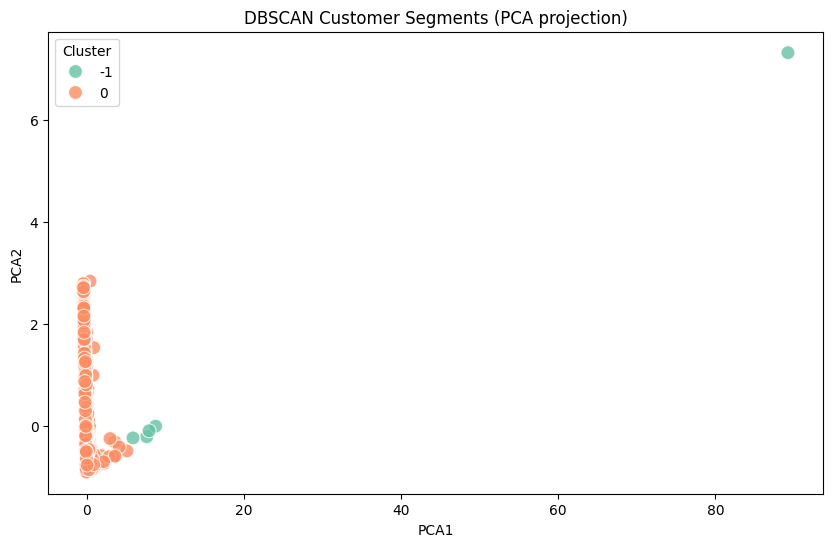


Explained variance ratio by 2 components: [0.65807112 0.33062685]


In [3]:
# ==========================================
# Step 1: Import libraries
# ==========================================
!pip install seaborn openpyxl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import numpy as np

# ==========================================
# Step 2: Load and clean data
# ==========================================
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Remove cancelled transactions
df_clean = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Reference date for Recency
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# ==========================================
# Step 3: Compute RFM metrics
# ==========================================
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# ==========================================
# Step 4: DBSCAN Clustering
# ==========================================
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)
rfm['Cluster'] = dbscan.fit_predict(X_scaled)

# Analyze clusters
n_clusters = len(set(rfm['Cluster'])) - (1 if -1 in rfm['Cluster'] else 0)
n_noise = list(rfm['Cluster']).count(-1)
noise_ratio = n_noise / len(rfm)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({noise_ratio:.2%} of data)")

# ==========================================
# Step 5: Cluster Profiling
# ==========================================
cluster_summary = (
    rfm.groupby('Cluster')
       .agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']})
       .round(1)
)
print("\nCluster Summary:")
print(cluster_summary)

# ==========================================
# Step 6: Visualization (PCA 2D)
# ==========================================
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster', palette='Set2',
    data=rfm, s=100, alpha=0.8
)
plt.title('DBSCAN Customer Segments (PCA projection)')
plt.legend(title='Cluster')
plt.show()

print("\nExplained variance ratio by 2 components:", pca.explained_variance_ratio_)

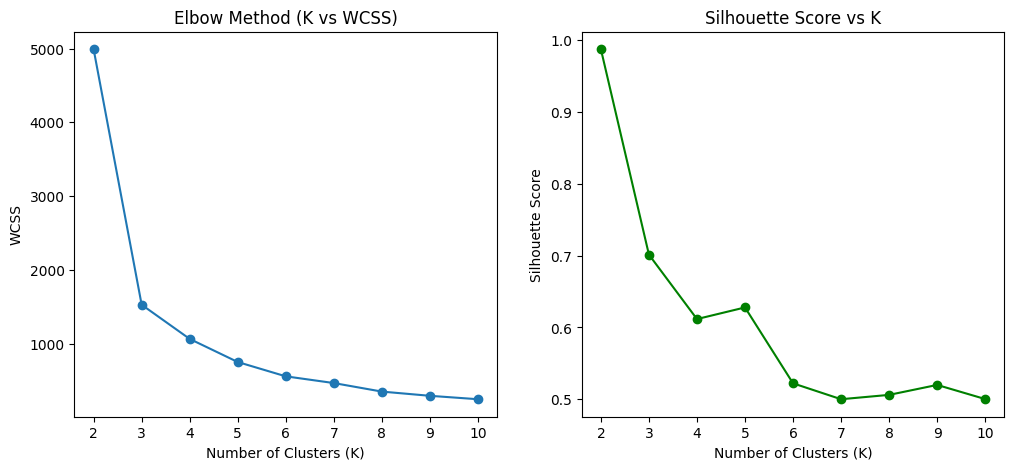


K-Means Cluster Summary:
               Recency Frequency   Monetary      
                  mean      mean       mean count
KMeans_Cluster                                   
0                 32.5       5.4     2628.7  2921
1                  1.0    2125.0  1691524.5     1
2                155.9       2.2      787.8   798
3                295.8       1.3      487.8   616


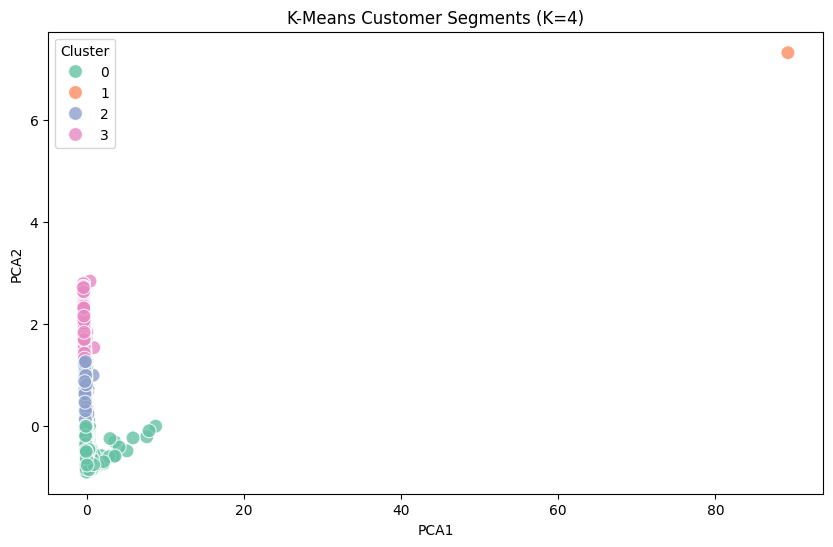

Explained variance ratio by 2 components: [0.65807112 0.33062685]


In [4]:
# ==========================================
# Step 1: Import and reuse your RFM data
# ==========================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `rfm` already exists (from DBSCAN section)
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================================
# Step 2: Choose optimal K using Elbow + Silhouette
# ==========================================
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow and silhouette side by side
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method (K vs WCSS)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# ==========================================
# Step 3: Fit final K-Means model
# ==========================================
optimal_k = 4  # choose based on plots
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# ==========================================
# Step 4: Cluster profiling
# ==========================================
kmeans_summary = (
    rfm.groupby('KMeans_Cluster')
       .agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']})
       .round(1)
)
print("\nK-Means Cluster Summary:")
print(kmeans_summary)

# ==========================================
# Step 5: Visualization (PCA 2D)
# ==========================================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster', 
    palette='Set2', 
    data=rfm, 
    s=100, 
    alpha=0.8
)
plt.title(f'K-Means Customer Segments (K={optimal_k})')
plt.legend(title='Cluster')
plt.show()

print("Explained variance ratio by 2 components:", pca.explained_variance_ratio_)

C:\Users\lionl\AppData\Local\Temp\ipykernel_12088\3267466197.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']



Top 10 DBSCAN Configurations:
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
20  2.5            3           2        2        0.000      0.8795
1   0.5            4           2       19        0.004      0.5876
2   0.5            5           2       23        0.005      0.5849
0   0.5            3           1       18        0.004         NaN
3   0.5            6           1       29        0.007         NaN
4   0.5            7           1       29        0.007         NaN
5   1.0            3           1       13        0.003         NaN
6   1.0            4           1       13        0.003         NaN
7   1.0            5           1       14        0.003         NaN
8   1.0            6           1       14        0.003         NaN


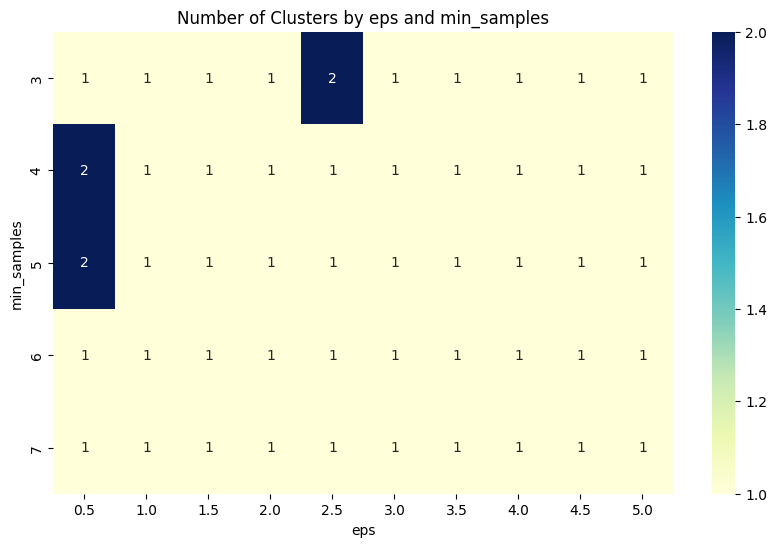

In [3]:
# ==========================================
# Step 1: Import Libraries
# ==========================================
!pip install seaborn openpyxl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# ==========================================
# Step 2: Load and Prepare RFM Data
# ==========================================
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Remove cancelled transactions
df_clean = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Reference date for Recency
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# Compute RFM features
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# ==========================================
# Step 3: Scale RFM Features
# ==========================================
X = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================================
# Step 4: Grid Search for DBSCAN Parameters
# ==========================================
eps_values = np.arange(0.5, 5.5, 0.5)
min_samples_values = range(3, 8)

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        # Only compute silhouette if at least 2 clusters exist
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': round(noise_ratio, 3),
            'silhouette': round(sil_score, 4) if not np.isnan(sil_score) else None
        })

# ==========================================
# Step 5: Review Results
# ==========================================
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by=['silhouette'], ascending=False)

print("\nTop 10 DBSCAN Configurations:")
print(df_results_sorted.head(10))

# ==========================================
# Step 6: Visualize Grid Search (fixed)
# ==========================================
plt.figure(figsize=(10,6))
pivot = df_results.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Number of Clusters by eps and min_samples')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.show()

🧮 Columns Explained
Column	Meaning
eps	The maximum distance between two samples for one to be considered as in the neighborhood of the other. Smaller eps = stricter clustering; larger eps = more points grouped together.
min_samples	Minimum number of points required to form a dense region (i.e., a cluster). Higher = more conservative clustering.
n_clusters	Number of clusters DBSCAN detected (excluding noise points).
n_noise	Number of points labeled as noise (-1 cluster).
noise_ratio	Fraction of total data labeled as noise (n_noise / total_points).
silhouette	Average silhouette score of non-noise points — measures cluster separation (range: -1 to +1). Higher = better-defined clusters.
🧠 Interpretation of Your Results
eps	min_samples	n_clusters	silhouette	Notes
2.5	3	2 clusters	0.8795	✅ Best configuration: very high silhouette → two well-separated clusters, almost no noise (0.000 noise ratio).
0.5	4	2 clusters	0.5876	Decent clustering, but less separation than above.
0.5–1.0	various	1 cluster	NaN silhouette	❌ Only one cluster formed — silhouette undefined (can’t measure cluster separation with a single group).
🟢 Conclusion

✅ Best configuration: eps = 2.5, min_samples = 3

2 meaningful clusters

almost no noise

very strong separation (silhouette ≈ 0.88 → excellent)

⚠️ Configurations with only 1 cluster aren’t useful — DBSCAN failed to detect distinct groups.